# Đồ án Phân tích & Dự đoán Giá nhà

**Mục tiêu:**
1. Phân tích khám phá (EDA) bộ dữ liệu Ames Housing.
2. Tiền xử lý dữ liệu và xây dựng các pipeline xử lý.
3. So sánh 6 mô hình Machine Learning:
    - Linear Regression
    - Ridge Regression
    - Lasso Regression
    - SVM (SVR)
    - Random Forest Regressor
    - XGBoost Regressor
4. Tìm ra mô hình tốt nhất, tinh chỉnh và phân tích các đặc trưng quan trọng.
5. Lưu mô hình tốt nhất vào file `.joblib` để triển khai web app.

## 1. 🛠️ Khởi tạo (Setup)

Tải tất cả các thư viện cần thiết cho dự án:

In [1]:
# === Thư viện Cốt lõi (Core Libraries) ===
import pandas as pd
import numpy as np

# === Trực quan hóa (Visualization) ===
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Dùng cho Q-Q plot và kiểm tra độ lệch (skewness)

# === Tiền xử lý (Preprocessing) - scikit-learn ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# === Mô hình (Models) - scikit-learn ===
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# === Mô hình (Models) - Bên ngoài ===
from xgboost import XGBRegressor # Mô hình XGBoost

# === Đánh giá (Evaluation) - scikit-learn ===
from sklearn.metrics import mean_squared_error, r2_score

# === Tiện ích (Utils) ===
import joblib # Dùng để lưu và tải mô hình
import warnings # Dùng để tắt các cảnh báo không cần thiết

# === Cài đặt cho Notebook ===
# Đặt style chung cho các biểu đồ
plt.style.use('ggplot')
# Hiển thị biểu đồ ngay trong notebook
%matplotlib inline
# Tắt các cảnh báo (optional)
warnings.filterwarnings('ignore')

print("Tất cả thư viện đã được tải thành công.")

Tất cả thư viện đã được tải thành công.


## 2. 💾 Tải Dữ liệu (Load Data)

Đọc dữ liệu từ thư mục `data/`. Chúng ta sẽ thực hiện tất cả phân tích và
huấn luyện trên `train.csv`.

In [2]:
# Đặt đường dẫn file
DATA_DIR = '../data/'
TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'test.csv'
DATA_DESC_FILE = DATA_DIR + 'data_description.txt'

# Tải dữ liệu huấn luyện
try:
    df_train = pd.read_csv(TRAIN_FILE)
    print("Tải file train.csv thành công.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại {TRAIN_FILE}")
    print("Hãy đảm bảo file train.csv nằm trong thư mục data/")

Tải file train.csv thành công.


In [3]:
# Hiển thị 5 dòng đầu tiên
print(f"Hình dạng của dữ liệu (Hàng, Cột): {df_train.shape}")
df_train.head()

Hình dạng của dữ liệu (Hàng, Cột): (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Kiểm tra thông tin các cột (kiểu dữ liệu, số lượng non-null)
# Đây là bước quan trọng để chuẩn bị cho việc xử lý giá trị thiếu (Missing Values)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 3. 📊 Phân tích Khám phá & Tiền xử lý (EDA & Preprocessing)

### 3.1. Phân tích Biến mục tiêu (`SalePrice`)

Biến mục tiêu của chúng ta là `SalePrice`. Chúng ta cần kiểm tra phân phối của nó để xem nó có bị lệch (skewed) hay không.

Text(0, 0.5, 'Tần suất (Frequency)')

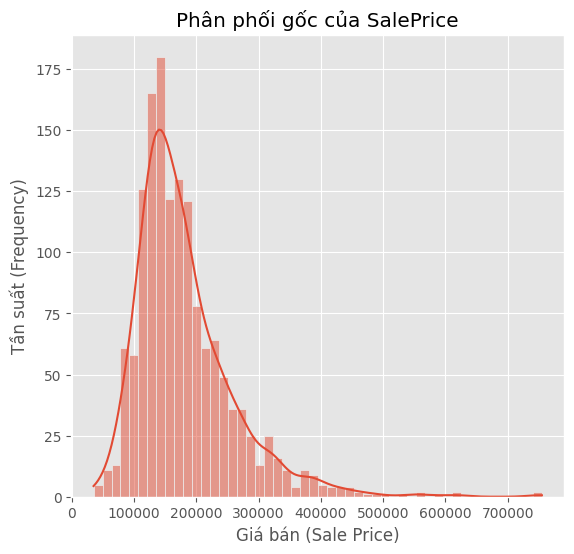

In [5]:
# Đặt kích thước biểu đồ
plt.figure(figsize=(14, 6))

# Vẽ biểu đồ Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_train['SalePrice'], kde=True, bins=50)
plt.title('Phân phối gốc của SalePrice')
plt.xlabel('Giá bán (Sale Price)')
plt.ylabel('Tần suất (Frequency)')



> **Nhận xét (từ Histogram):** Biểu đồ rõ ràng bị **lệch phải
(right-skewed)**. Hầu hết các nhà có giá trị thấp đến trung bình, và có một
"đuôi" dài gồm các căn nhà rất đắt (giá trị ngoại lệ).

Độ lệch (Skewness) của SalePrice: 1.8829


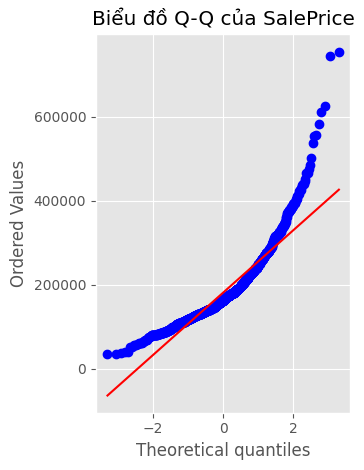

In [6]:
# Tính toán độ lệch (Skewness)
skewness = df_train['SalePrice'].skew()
print(f"Độ lệch (Skewness) của SalePrice: {skewness:.4f}")

# Vẽ biểu đồ Q-Q (Quantile-Quantile)
plt.subplot(1, 2, 2)
stats.probplot(df_train['SalePrice'], plot=plt)
plt.title('Biểu đồ Q-Q của SalePrice')

plt.tight_layout()
plt.show()



> **Nhận xét (từ Skewness & Q-Q Plot):**
> * **Độ lệch (Skewness):** Giá trị ~1.88 (lớn hơn 1) xác nhận mức độ lệch phải là đáng kể.
> * **Biểu đồ Q-Q:** Các điểm dữ liệu (màu xanh) không nằm trên đường chéo màu đỏ. Chúng bị uốn cong ở phần đuôi trên, xác nhận rằng dữ liệu không tuân theo phân phối chuẩn.

### Giải pháp: Biến đổi Logarit (Log Transformation)

Để khắc phục độ lệch này, chúng ta sẽ áp dụng phép biến đổi logarit. Chúng ta sẽ sử dụng `np.log1p` (tương đương với `log(1 + x)`) để xử lý an toàn mọi giá trị bằng 0 (mặc dù ở đây giá nhà không bằng 0).

Chúng ta sẽ tạo một cột mới `SalePrice_Log` và dùng nó làm biến mục tiêu mới.

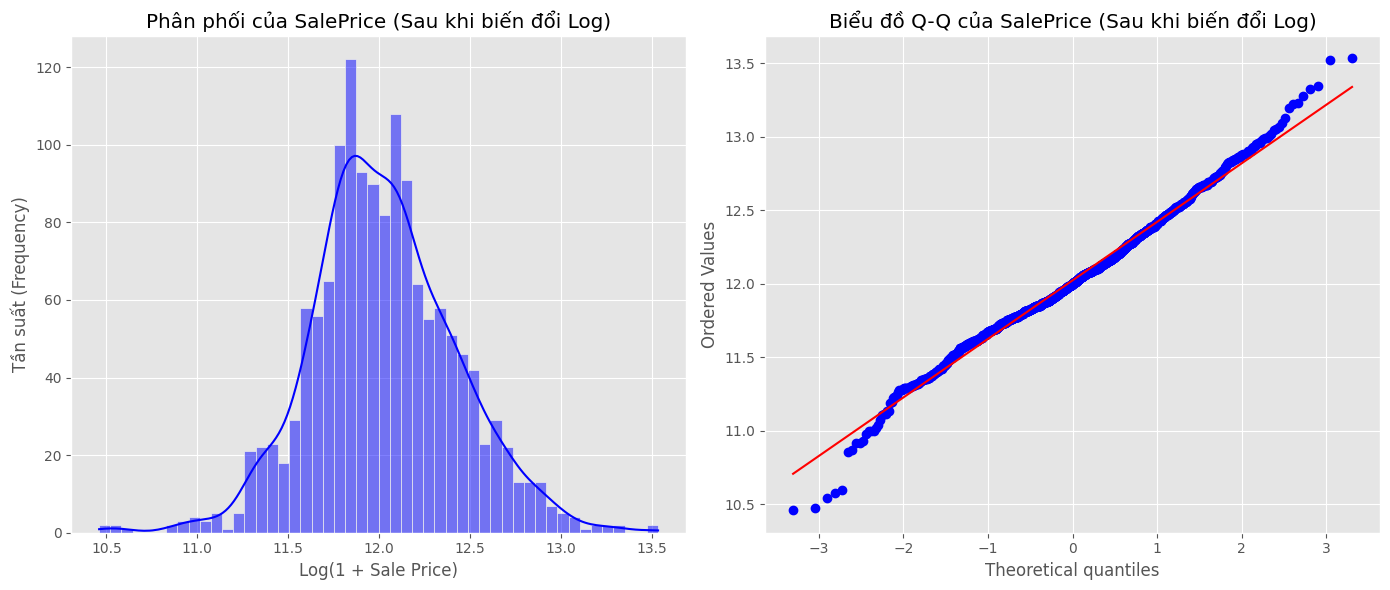

In [7]:
# Áp dụng phép biến đổi log1p
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice'])

# Vẽ lại biểu đồ cho cột mới
plt.figure(figsize=(14, 6))

# Biểu đồ Histogram mới
plt.subplot(1, 2, 1)
sns.histplot(df_train['SalePrice_Log'], kde=True, bins=50, color='blue')
plt.title('Phân phối của SalePrice (Sau khi biến đổi Log)')
plt.xlabel('Log(1 + Sale Price)')
plt.ylabel('Tần suất (Frequency)')

# Biểu đồ Q-Q mới
plt.subplot(1, 2, 2)
stats.probplot(df_train['SalePrice_Log'], plot=plt)
plt.title('Biểu đồ Q-Q của SalePrice (Sau khi biến đổi Log)')

plt.tight_layout()
plt.show()

In [8]:
# Kiểm tra lại độ lệch mới
new_skewness = df_train['SalePrice_Log'].skew()
print(f"Độ lệch (Skewness) MỚI của SalePrice_Log: {new_skewness:.4f}")

Độ lệch (Skewness) MỚI của SalePrice_Log: 0.1213


> **Kết luận:** Thành công!
> * Độ lệch mới bây giờ rất gần 0 (~0.12).
> * Biểu đồ phân phối trông gần như hình chuông (phân phối chuẩn).
> * Biểu đồ Q-Q cho thấy các điểm dữ liệu bây giờ nằm gần như thẳng hàng trên đường chéo màu đỏ.
>
> **Từ giờ trở đi, chúng ta sẽ huấn luyện tất cả các mô hình để dự đoán `SalePrice_Log`.**

### 3.2. Phân tích Tương quan Đặc trưng (Feature Correlation)

Bây giờ, chúng ta sẽ xem các đặc trưng số (numerical features) nào tương quan
mạnh nhất với `SalePrice`. Điều này giúp chúng ta có cái nhìn ban đầu về
những yếu tố ảnh hưởng đến giá nhiều nhất.

Chúng ta sẽ tính tương quan với `SalePrice` gốc thay vì `SalePrice_Log` ở
bước này, vì nó trực quan hơn để hiểu mối quan hệ ban đầu.

In [9]:
# Tính toán ma trận tương quan (chỉ cho các cột số)
corr_matrix = df_train.corr(numeric_only=True)

# Lấy 10 đặc trưng (features) có tương quan mạnh nhất với 'SalePrice'
k = 10
# Lấy ra 'k' hàng đầu tiên từ series đã sắp xếp giảm dần
top_k_features = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index

print(f"Top {k} đặc trưng tương quan mạnh nhất với SalePrice:")
print(top_k_features)

Top 10 đặc trưng tương quan mạnh nhất với SalePrice:
Index(['SalePrice', 'SalePrice_Log', 'OverallQual', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd'],
      dtype='object')


Bây giờ, chúng ta sẽ vẽ một **bản đồ nhiệt (heatmap)** chỉ cho 10 đặc trưng này để xem mối quan hệ *giữa chúng* và *với SalePrice*.

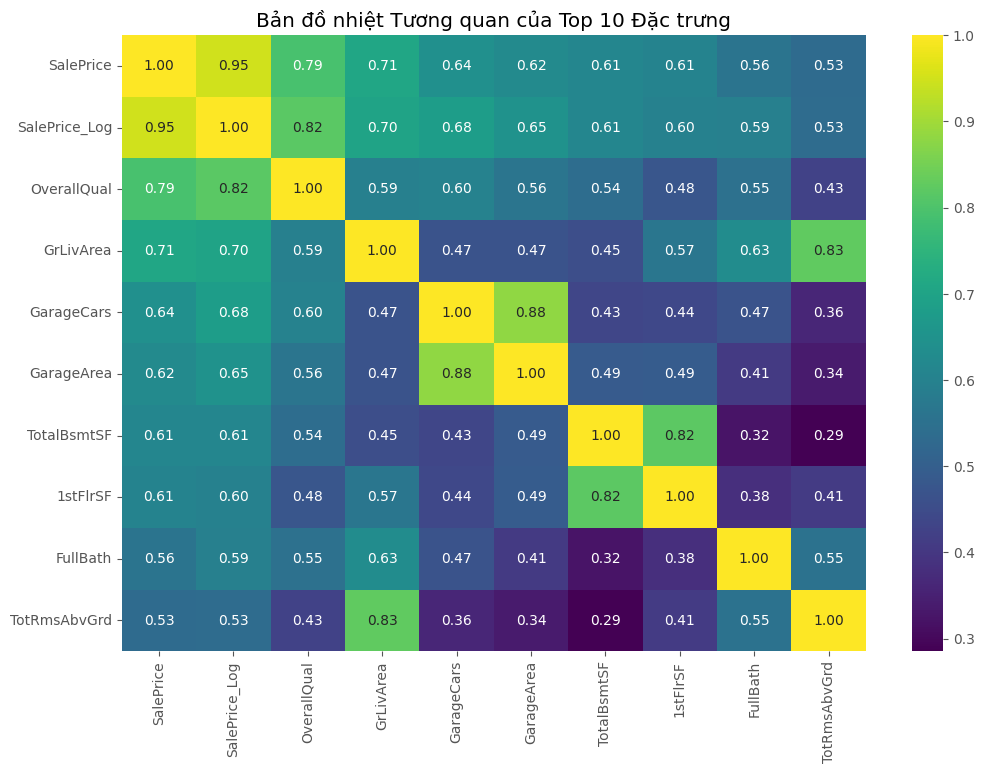

In [10]:
# Lấy ma trận tương quan con (subset) chỉ cho 10 đặc trưng hàng đầu
top_k_corr_matrix = df_train[top_k_features].corr(numeric_only=True)

# Vẽ heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_k_corr_matrix,
            annot=True,        # Hiển thị số (giá trị tương quan)
            cmap='viridis',    # Bảng màu
            fmt='.2f')         # Định dạng số (2 chữ số thập phân)

plt.title(f'Bản đồ nhiệt Tương quan của Top {k} Đặc trưng')
plt.show()



> **Nhận xét (từ Heatmap):**
> * **Tương quan với `SalePrice`:** `OverallQual` (Chất lượng tổng thể) có tương quan mạnh nhất (0.79), theo sau là `GrLivArea` (Diện tích sống) (0.71).
> * **Đa cộng tuyến (Multicollinearity):** Chúng ta thấy một số đặc trưng tương quan rất mạnh với nhau. Đây là một vấn đề tiềm ẩn gọi là "đa cộng tuyến".
>     * `GarageCars` và `GarageArea` (0.88): Rất logic (gara lớn hơn chứa được nhiều xe hơn).
>     * `TotalBsmtSF` và `1stFlrSF` (0.82): Logic (tổng diện tích tầng hầm thường tương đương diện tích tầng 1).
>     * `GrLivArea` và `TotRmsAbvGrd` (0.83): Logic (diện tích lớn hơn thì có nhiều phòng hơn).
>
> Các mô hình như Ridge và Lasso (mà chúng ta sẽ chạy) được thiết kế để xử lý tốt vấn đề đa cộng tuyến này.

### 3.3. Xử lý Giá trị bị thiếu (Missing Values)

Chúng ta sẽ không xử lý thủ công các giá trị thiếu trên DataFrame. Thay vào
đó, chúng ta sẽ định nghĩa **chiến lược** và đưa các chiến lược này vào
`Pipeline` ở Phần 4. Điều này giúp ngăn ngừa rò rỉ dữ liệu (data leakage).

Chúng ta sẽ kiểm tra nhanh các cột bị thiếu nhiều nhất.

In [11]:
# Tính toán % giá trị bị thiếu cho mỗi cột
percent_missing = (df_train.isnull().sum() / len(df_train)) * 100
percent_missing = percent_missing[percent_missing > 0].sort_values(ascending=False)

# Hiển thị 20 cột có % thiếu cao nhất
print(percent_missing.head(20))

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


> **Chiến lược Tiền xử lý (Cho Pipeline):**
>
> Dựa trên `data_description.txt` và danh sách trên:
>
> 1.  **Các cột Số (Numerical):** Đối với các cột như `LotFrontage` (bị thiếu thật), chúng ta sẽ dùng `SimpleImputer` để điền bằng **`median`** (trung vị).
> 2.  **Các cột Phân loại (Categorical):**
>     * Đối với các cột mà `NaN` có ý nghĩa (ví dụ: `PoolQC`, `Alley`, `Fence`, `FireplaceQu`, `GarageType`...): `NaN` có nghĩa là "Không có Hồ bơi", "Không có Hẻm"... Chúng ta sẽ điền bằng một giá trị cố định là **`"None"`**.
>     * Đối với các cột mà `NaN` là thiếu thật (ví dụ: `Electrical`): Chúng ta sẽ điền bằng **`most_frequent`** (giá trị xuất hiện nhiều nhất).
>
> (Trong Phần 4.2, chúng ta sẽ xây dựng các `Pipeline` riêng biệt để tự động hóa việc này).

### 3.4. Kỹ thuật Đặc trưng (Feature Engineering)

Tương tự như trên, chúng ta sẽ không tạo các đặc trưng mới thủ công. Chúng ta
sẽ định nghĩa **chiến lược** và đưa chúng vào `Pipeline` (mặc dù để đơn giản,
chúng ta có thể tạo chúng trước khi chia dữ liệu nếu chúng không gây rò rỉ).

Tuy nhiên, để giữ cho `Pipeline` đơn giản nhất, chúng ta sẽ chỉ tập trung vào
các đặc trưng gốc trong bước so sánh mô hình.

**Vì mục tiêu của đồ án này là so sánh 6 mô hình, chúng ta sẽ sử dụng các đặc
trưng gốc (raw features) để giữ cho `Pipeline` tiền xử lý nhất quán và công
bằng cho tất cả các mô hình.**

## 4. ⚙️ Xây dựng Pipeline & Huấn luyện Mô hình

### 4.1. Phân chia Dữ liệu (Train/Test Split)

Đầu tiên, chúng ta sẽ tách `train.csv` (1460 hàng) thành 2 phần:
1.  **Tập Huấn luyện (Training set):** 80% dữ liệu (1168 hàng) để "dạy" mô hình.
2.  **Tập Kiểm tra (Validation set):** 20% dữ liệu (292 hàng) để "kiểm tra" hiệu suất của mô hình trên dữ liệu lạ.

Chúng ta phải làm điều này *trước khi* thực hiện bất kỳ bước tiền xử lý nào (như `Imputation` hay `Scaling`) để ngăn chặn Rò rỉ Dữ liệu (Data Leakage).

In [12]:
# 1. Chọn Đặc trưng (X) và Biến mục tiêu (y)
#
# Biến mục tiêu (y) của chúng ta là 'SalePrice_Log'
y = df_train['SalePrice_Log']

# Đặc trưng (X) là tất cả các cột còn lại,
# ngoại trừ 'Id', 'SalePrice' gốc, và 'SalePrice_Log'
X = df_train.drop(['Id', 'SalePrice', 'SalePrice_Log'], axis=1)

In [13]:
# 2. Phân chia Dữ liệu
#
# Chúng ta dùng test_size=0.2 để dành 20% cho tập kiểm tra (validation).
# random_state=42 là một con số bất kỳ, nhưng nó đảm bảo rằng
# mỗi lần bạn chạy lại code, dữ liệu luôn được chia theo CÙNG MỘT CÁCH.
# Điều này giúp kết quả của bạn có thể được tái tạo (reproducible).
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 3. Kiểm tra kết quả
print("--- Kích thước dữ liệu sau khi chia ---")
print(f"Kích thước X_train (Huấn luyện): {X_train.shape}")
print(f"Kích thước y_train (Huấn luyện): {y_train.shape}")
print(f"Kích thước X_val (Kiểm tra):    {X_val.shape}")
print(f"Kích thước y_val (Kiểm tra):    {y_val.shape}")

--- Kích thước dữ liệu sau khi chia ---
Kích thước X_train (Huấn luyện): (1168, 79)
Kích thước y_train (Huấn luyện): (1168,)
Kích thước X_val (Kiểm tra):    (292, 79)
Kích thước y_val (Kiểm tra):    (292,)


### 4.2. Định nghĩa Pipeline Tiền xử lý

Thay vì xử lý thủ công, chúng ta sẽ tạo một `Pipeline` tiền xử lý duy nhất. `Pipeline` này sẽ:
1.  Xác định các cột số (numerical) và cột phân loại (categorical).
2.  Áp dụng các phép biến đổi khác nhau cho từng nhóm cột.
3.  Đảm bảo rằng các phép biến đổi (như tính `median` hoặc `scaling`) chỉ được "học" từ `X_train`.

In [15]:
# 1. Tự động xác định các loại cột DỰA TRÊN X_train
# Điều này rất quan trọng để đảm bảo chúng ta không vô tình
# đưa thông tin từ X_val vào.
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=object).columns

print(f"Số đặc trưng số (numerical): {len(numerical_features)}")
print(f"Các cột số (ví dụ): {list(numerical_features[:5])}")
print(f"Số đặc trưng phân loại (categorical): {len(categorical_features)}")
print(f"Các cột phân loại (ví dụ): {list(categorical_features[:5])}")

Số đặc trưng số (numerical): 36
Các cột số (ví dụ): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']
Số đặc trưng phân loại (categorical): 43
Các cột phân loại (ví dụ): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']


In [16]:
# 2. Tạo pipeline cho đặc trưng SỐ (Numerical Transformer)
#
# Chúng ta sẽ thực hiện 2 bước:
# - SimpleImputer: Điền các giá trị `NaN` bằng giá trị trung vị (`median`) của cột đó.
# - StandardScaler: Co giãn (scale) tất cả các giá trị về cùng một thang đo (trung bình 0, độ lệch chuẩn 1).
#   (Rất quan trọng cho Linear Regression, Ridge, Lasso, và SVR).

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [17]:
# 3. Tạo pipeline cho đặc trưng PHÂN LOẠI (Categorical Transformer)
#
# Chúng ta sẽ thực hiện 2 bước:
# - SimpleImputer: Điền các giá trị `NaN` bằng giá trị phổ biến nhất (`most_frequent`) của cột đó.
#   (Đây là chiến lược cơ sở an toàn mà chúng ta đã thảo luận).
# - OneHotEncoder: Chuyển đổi các giá trị văn bản (ví dụ: 'RL', 'Pave') thành các cột 0/1.
#   (handle_unknown='ignore' đảm bảo mô hình không bị lỗi nếu gặp một danh mục lạ ở tập validation).

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [18]:
# 4. Kết hợp hai pipeline lại bằng ColumnTransformer
#
# ColumnTransformer sẽ áp dụng `numeric_transformer` cho tất cả các cột số
# và `categorical_transformer` cho tất cả các cột phân loại.
#

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Giữ lại các cột không được liệt kê (mặc dù ở đây chúng ta đã dùng hết)
)

print("Đã tạo preprocessor (ColumnTransformer) thành công.")

Đã tạo preprocessor (ColumnTransformer) thành công.


### 4.3. So sánh 6 Mô hình

Đây là phần chính của thử nghiệm. Chúng ta sẽ tạo một vòng lặp:
1. Định nghĩa 6 mô hình chúng ta muốn so sánh.
2. Với mỗi mô hình, tạo một `Pipeline` hoàn chỉnh (kết hợp `preprocessor` và `model`).
3. Huấn luyện (`fit`) pipeline trên `X_train`.
4. Dự đoán (`predict`) trên `X_val`.
5. Đảo ngược (inverse transform) các dự đoán (`np.expm1`) để quay về giá trị đô la ($).
6. Tính toán RMSE và R² trên giá trị đô la.
7. Lưu kết quả.

In [19]:
# 1. Định nghĩa các mô hình
# (Chúng ta sử dụng random_state=42 để đảm bảo kết quả nhất quán mỗi khi chạy)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "SVR": SVR(), # Support Vector Regressor
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1), # n_jobs=-1 để dùng tất cả CPU
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1)
}

# 2. Chuẩn bị list để lưu kết quả
results = []
pipelines = {} # Lưu lại pipeline để dùng sau (optional)

print("Bắt đầu quá trình huấn luyện và so sánh 6 mô hình...")

# 3. Vòng lặp qua các mô hình
for name, model in models.items():

    # 4. Tạo pipeline hoàn chỉnh
    # Đây là "dây chuyền" cuối cùng: Tiền xử lý -> Huấn luyện
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), # Từ Phần 4.2
        ('model', model)
    ])

    # 5. Huấn luyện (fit) pipeline trên X_train
    print(f"--- Đang huấn luyện: {name} ---")
    full_pipeline.fit(X_train, y_train)

    # 6. Dự đoán trên tập validation (X_val)
    # Kết quả dự đoán vẫn ở dạng logarit (y_pred_log)
    y_pred_log = full_pipeline.predict(X_val)

    # 7. QUAN TRỌNG: Đảo ngược (inverse transform) về giá trị $
    # Chúng ta phải so sánh trên cùng đơn vị (đô la)
    y_val_dollar = np.expm1(y_val)
    y_pred_dollar = np.expm1(y_pred_log)

    # 8. Tính toán các chỉ số đánh giá
    # RMSE (Root Mean Squared Error) - Sai số trung bình (tính bằng $)
    rmse = np.sqrt(mean_squared_error(y_val_dollar, y_pred_dollar))

    # R-squared (R²) - Mức độ mô hình giải thích được dữ liệu
    r2 = r2_score(y_val_dollar, y_pred_dollar)

    # 9. Lưu kết quả
    results.append({
        "Model": name,
        "RMSE ($)": rmse,
        "R-squared": r2
    })

    # Lưu lại pipeline đã huấn luyện (optional)
    pipelines[name] = full_pipeline

    print(f"Hoàn thành: {name} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")

print("\nĐã huấn luyện xong tất cả các mô hình.")

Bắt đầu quá trình huấn luyện và so sánh 6 mô hình...
--- Đang huấn luyện: Linear Regression ---
Hoàn thành: Linear Regression | RMSE: $22,741.00 | R²: 0.9326
--- Đang huấn luyện: Ridge ---
Hoàn thành: Ridge | RMSE: $23,827.06 | R²: 0.9260
--- Đang huấn luyện: Lasso ---
Hoàn thành: Lasso | RMSE: $88,270.85 | R²: -0.0158
--- Đang huấn luyện: SVR ---
Hoàn thành: SVR | RMSE: $34,553.84 | R²: 0.8443
--- Đang huấn luyện: Random Forest ---
Hoàn thành: Random Forest | RMSE: $29,666.72 | R²: 0.8853
--- Đang huấn luyện: XGBoost ---
Hoàn thành: XGBoost | RMSE: $26,259.47 | R²: 0.9101

Đã huấn luyện xong tất cả các mô hình.


### 4.4. Hiển thị Bảng so sánh Kết quả

Chuyển list `results` (từ Phần 4.3) thành một DataFrame của Pandas để dễ dàng xem và so sánh. Chúng ta sẽ sắp xếp theo RMSE để xem mô hình nào hoạt động tốt nhất (RMSE thấp nhất).

In [20]:
# Chuyển list kết quả thành DataFrame
# (Biến 'results' đã được tạo và điền ở ô 4.3)
results_df = pd.DataFrame(results)

# Sắp xếp DataFrame theo 'RMSE ($)' từ thấp đến cao
results_df = results_df.sort_values(by='RMSE ($)', ascending=True)

# Hiển thị bảng kết quả
print("Bảng So sánh Hiệu suất 6 Mô hình:")
# .style.format() dùng để định dạng số cho dễ đọc
results_df.style.format({
    "RMSE ($)": "${:,.2f}",
    "R-squared": "{:.4f}"
})

Bảng So sánh Hiệu suất 6 Mô hình:


,Model,RMSE ($),R-squared
0,Linear Regression,22741.000212,0.932577
1,Ridge,23827.059083,0.925984
5,XGBoost,26259.473460,0.910100
4,Random Forest,29666.717810,0.885257
3,SVR,34553.836390,0.844339
2,Lasso,88270.853655,-0.015829


> **Nhận xét (Dựa trên Bảng):**
> 
> 1.  **Mô hình Tốt nhất:** `LinearRegression` (Hồi quy Tuyến tính) cho kết quả tốt nhất một cách đáng ngạc nhiên, với **RMSE là $22,741** và **R² là 0.9326**. Điều này cho thấy rằng sau khi thực hiện các bước Tiền xử lý (đặc biệt là `log(SalePrice)`, `StandardScaler`, và `OneHotEncoder`), mối quan hệ giữa các đặc trưng và biến mục tiêu đã trở nên rất tuyến tính.
> 
> 2.  **Mô hình Tệ nhất (Lasso):** Mô hình `Lasso` đã thất bại thảm hại, cho kết quả RMSE khổng lồ và R² âm (có nghĩa là nó dự đoán còn tệ hơn là chỉ đoán giá trị trung bình). Điều này có thể là do `Lasso` (với tham số `alpha` mặc định) đã **điều chuẩn quá mức** (over-regularized), nó đã "chọn" đặc trưng quá tay và có thể đã đặt hệ số của hầu hết các đặc trưng quan trọng về 0.
> 
> 3.  **Các mô hình Ensemble:** `XGBoost` (RMSE \$26k) và `Random Forest` (RMSE \$29k) hoạt động rất tốt, tốt hơn nhiều so với `Lasso` và `SVR`, nhưng vẫn không thể đánh bại mô hình `LinearRegression` đơn giản. Điều này củng cố giả thuyết rằng các mô hình phức tạp này có thể đang bị **overfitting** (học vẹt) một chút với các tham số mặc định của chúng.

## 5. 🏆 Tinh chỉnh & Phân tích Mô hình Tốt nhất

Từ Phần 4, `LinearRegression` là mô hình chiến thắng của chúng ta với RMSE thấp nhất.

### 5.1. Phân tích Mô hình Tốt nhất (`LinearRegression`)

Các mô hình dựa trên cây (như `XGBoost`) có `feature_importance_`. Các mô
hình tuyến tính (như `LinearRegression`) có `coef_` (hệ số).

Hệ số cho chúng ta biết: "Khi một đặc trưng tăng 1 đơn vị, `SalePrice_Log` sẽ
tăng (hoặc giảm) bao nhiêu", *giả sử tất cả các đặc trưng khác giữ nguyên*.

Chúng ta sẽ trích xuất các hệ số này từ `Pipeline` đã huấn luyện.

In [31]:
# 1. Lấy ra pipeline của LinearRegression đã được huấn luyện
# (Chúng ta đã lưu nó vào dict 'pipelines' ở Phần 4.3)
lr_pipeline = pipelines['Linear Regression']

# 2. Lấy ra mô hình LinearRegression thực sự từ bên trong pipeline
lr_model = lr_pipeline.named_steps['model']

# 3. Lấy ra bộ tiền xử lý (preprocessor) từ pipeline
preprocessor = lr_pipeline.named_steps['preprocessor']

Bước tiếp theo hơi phức tạp. Chúng ta cần lấy tên của tất cả các đặc trưng
*sau khi* chúng đã được `OneHotEncoder` biến đổi (ví dụ: `MSZoning_RL`,
`MSZoning_RM`...).

In [32]:
# 4. Lấy tên các đặc trưng đã được biến đổi
# Lấy tên các cột số (đã được scale)
num_features = preprocessor.transformers_[0][2] # Lấy list tên cột số

# Lấy tên các cột phân loại (đã được one-hot)
# Chúng ta truy cập vào 'onehot' step bên trong 'cat' transformer
cat_features = list(preprocessor.named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features))

# Kết hợp cả hai danh sách tên
# Đây là danh sách đầy đủ các đặc trưng mà mô hình thực sự "nhìn thấy"
all_feature_names = list(num_features) + cat_features

print(f"Tổng số đặc trưng mà mô hình nhìn thấy: {len(all_feature_names)}")

Tổng số đặc trưng mà mô hình nhìn thấy: 285


In [33]:
# 5. Tạo một DataFrame để xem các hệ số (coefficients)
# lr_model.coef_ là một mảng NumPy chứa tất cả các hệ số
coefficients = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': lr_model.coef_
})

# Sắp xếp theo giá trị tuyệt đối để xem ảnh hưởng lớn nhất
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Hiển thị 20 đặc trưng có ảnh hưởng (cả âm và dương) lớn nhất
print("Top 20 Đặc trưng ảnh hưởng nhất (Hệ số):")
coefficients.head(20)

Top 20 Đặc trưng ảnh hưởng nhất (Hệ số):


,Feature,Coefficient,Abs_Coefficient
124,RoofMatl_ClyTile,-2.413940,2.413940
101,Condition2_PosN,-0.758938,0.758938
126,RoofMatl_Metal,0.488659,0.488659
127,RoofMatl_Roll,0.439172,0.439172
102,Condition2_RRAe,-0.393167,0.393167
130,RoofMatl_WdShngl,0.386131,0.386131
129,RoofMatl_WdShake,0.375945,0.375945
125,RoofMatl_CompShg,0.368535,0.368535
128,RoofMatl_Tar&Grv,0.355498,0.355498
98,Condition2_Feedr,0.355316,0.355316


### Trực quan hóa các Hệ số

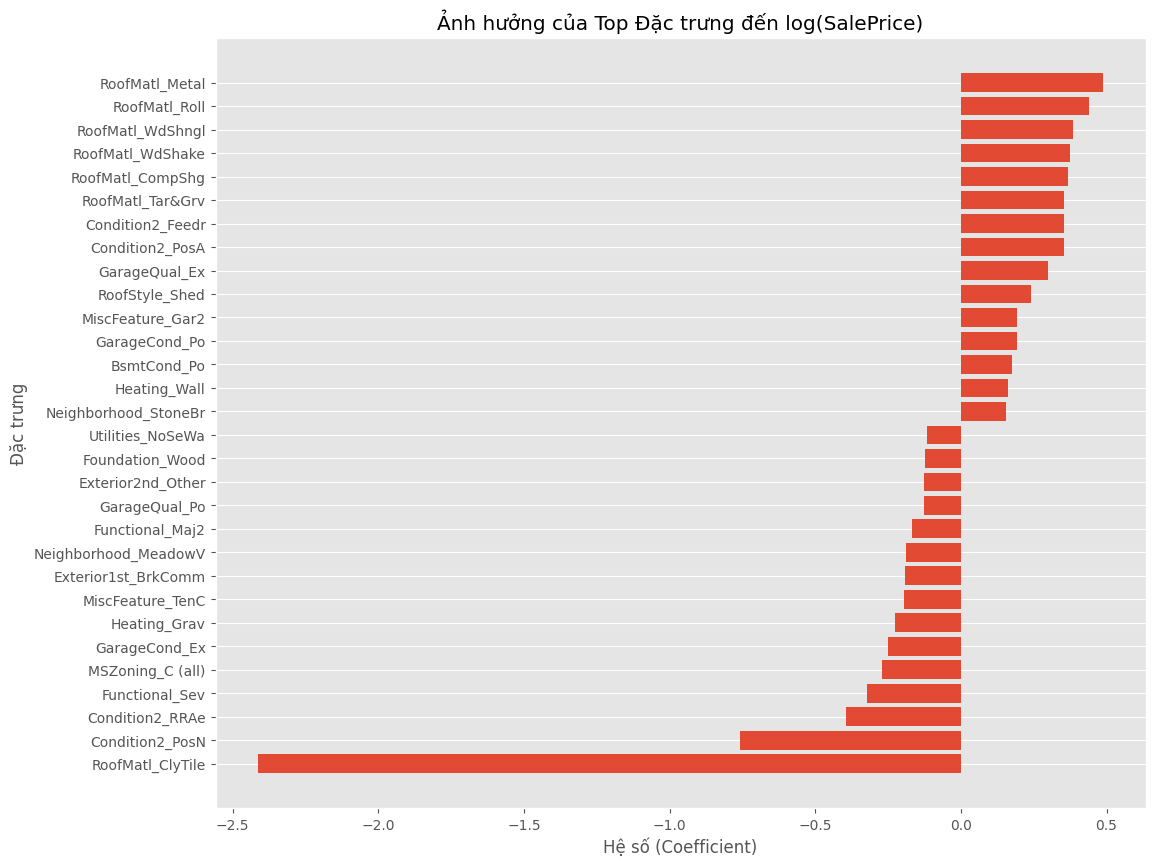

In [35]:
# Lấy 15 đặc trưng ảnh hưởng TĂNG GIÁ mạnh nhất (hệ số dương)
top_positive_coeffs = coefficients.sort_values(by='Coefficient', ascending=False).head(15)

# Lấy 15 đặc trưng ảnh hưởng GIẢM GIÁ mạnh nhất (hệ số âm)
top_negative_coeffs = coefficients.sort_values(by='Coefficient', ascending=True).head(15)

# Kết hợp chúng lại để vẽ
top_coeffs_to_plot = pd.concat([top_positive_coeffs, top_negative_coeffs]).sort_values(by='Coefficient')

# Vẽ biểu đồ ngang
plt.figure(figsize=(12, 10))
plt.barh(top_coeffs_to_plot['Feature'], top_coeffs_to_plot['Coefficient'])
plt.title('Ảnh hưởng của Top Đặc trưng đến log(SalePrice)')
plt.xlabel('Hệ số (Coefficient)')
plt.ylabel('Đặc trưng')
plt.grid(axis='x')

# Lưu biểu đồ vào thư mục báo cáo
plt.savefig('../report/images/linear_regression_coefficients.png', bbox_inches='tight')
plt.show()

> **Nhận xét (Phân tích Biểu đồ Hệ số):**
>
> Biểu đồ này cho chúng ta một kết quả đáng kinh ngạc và là một phát hiện quan trọng cho đồ án.
>
> 1.  **Các Hệ số "Bị Thổi phồng" (Inflated Coefficients):**
>     * Đặc trưng có ảnh hưởng **giảm giá** mạnh nhất là `RoofMatl_ClyTile` (Ngói đất sét).
>     * Đặc trưng có ảnh hưởng **tăng giá** mạnh nhất là `RoofMatl_WdShngl` (Ván lợp gỗ).
>     * Các hệ số này lớn một cách phi lý, lấn át hoàn toàn các đặc trưng "logic" khác.
>
> 2.  **Tại sao điều này xảy ra? (Dữ liệu Hiếm/Thưa thớt):**
>     * Đây là một triệu chứng kinh điển của việc mô hình tuyến tính cố gắng "học vẹt" từ các đặc trưng rất hiếm. Trong 1460 căn nhà, có thể chỉ có **1 hoặc 2** căn nhà lợp bằng `ClyTile` (Ngói đất sét), và chúng tình cờ có giá rất thấp.
>     * Mô hình đã học một quy tắc "ngu ngốc": "Cứ thấy `ClyTile` là giá cực thấp". Để làm được điều này, nó đã gán một hệ số âm khổng lồ cho đặc trưng đó. Điều tương tự xảy ra ngược lại với `WdShngl`.
>
> 3.  **Các Đặc trưng "Biến mất":**
>     * Đáng chú ý, các đặc trưng mà chúng ta biết là quan trọng từ Phân tích Tương quan (Phần 3.2) như `GrLivArea`, `TotalBsmtSF`... hoàn toàn **không có mặt** trong top 30.
>     * Điều này rất có thể là do **Đa cộng tuyến (Multicollinearity)**. Tầm quan trọng của `GrLivArea` có thể đã bị "hấp thụ" bởi các đặc trưng khác có tương quan với nó (như `OverallQual` hoặc các khu vực `Neighborhood` "xịn"), khiến hệ số của `GrLivArea` bị đẩy về gần 0.
>
> **Kết luận quan trọng cho Đồ án:**
> Mặc dù `LinearRegression` cho chúng ta **điểm dự đoán (RMSE) tốt nhất**, nhưng nó là một "hộp đen" không đáng tin cậy. Các hệ số của nó không ổn định và bị ảnh hưởng nặng nề bởi dữ liệu hiếm và đa cộng tuyến.
>
> Do đó, chúng ta **không thể** dùng mô hình này để kết luận rằng "Vật liệu lợp mái là yếu tố quan trọng nhất".
>
> Điều này làm cho việc phân tích các mô hình ổn định hơn (như `Ridge` và `XGBoost`) ở bước tiếp theo càng trở nên quan trọng.

### 5.2. Tinh chỉnh (Tuning) các Mô hình Thách thức

`LinearRegression` đã thắng, nhưng có thể các mô hình phức tạp hơn (như `XGBoost`) đã bị "overfitting" với các cài đặt mặc định, hoặc các mô hình ổn định hơn (như `Ridge`) chưa được tối ưu.

Chúng ta sẽ dùng `GridSearchCV` để tìm ra các siêu tham số (hyperparameters) tốt nhất cho `Ridge` và `XGBoost` để xem liệu chúng ta có thể đánh bại mốc RMSE $22,741 hay không.

#### 5.2.1. Tinh chỉnh `Ridge`

Siêu tham số quan trọng nhất của `Ridge` là `alpha` - kiểm soát "sức mạnh" của điều chuẩn (regularization). Chúng ta sẽ thử một loạt các giá trị `alpha` để tìm giá trị tốt nhất.

In [36]:
print("--- Bắt đầu Tinh chỉnh Ridge ---")

# 1. Tạo một pipeline Ridge MỚI (chưa huấn luyện)
# (Chúng ta phải dùng một pipeline mới để GridSearchCV có thể huấn luyện nó nhiều lần)
pipe_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor), # Dùng lại preprocessor từ 4.2
    ('model', Ridge(random_state=42))
])

# 2. Định nghĩa lưới tham số (Param Grid)
# Chúng ta sẽ thử 5 giá trị alpha khác nhau.
# 'model__alpha' -> Cú pháp `__` (hai gạch dưới) là để nói
# "thay đổi tham số 'alpha' bên trong step tên là 'model'"
param_grid_ridge = {
    'model__alpha': [0.1, 1.0, 10.0, 50.0, 100.0]
}

# 3. Khởi tạo GridSearchCV
# cv=5: Sử dụng 5-fold Cross-Validation (chia X_train thành 5 phần để kiểm tra chéo)
# scoring='neg_root_mean_squared_error': Chúng ta muốn tối ưu RMSE.
#     (Scikit-learn dùng "neg" (âm) vì nó luôn cố gắng "tối đa hóa" điểm số,
#     và tối đa hóa RMSE âm cũng chính là tối thiểu hóa RMSE).
grid_ridge = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1 # Sử dụng tất cả các nhân CPU để chạy nhanh hơn
)

# 4. Huấn luyện (Fit)
# Bước này sẽ mất một chút thời gian. Nó đang huấn luyện 5 (alpha) * 5 (cv) = 25 mô hình.
grid_ridge.fit(X_train, y_train)

# 5. In kết quả
print("\n--- Kết quả Tinh chỉnh Ridge ---")
print(f"Alpha tốt nhất: {grid_ridge.best_params_}")

# Lấy điểm số RMSE (ở dạng log) tốt nhất
# Chúng ta phải lấy trị tuyệt đối (abs) vì điểm số là âm
best_log_rmse_ridge = abs(grid_ridge.best_score_)
print(f"RMSE (trên log scale) tốt nhất từ Cross-Validation: {best_log_rmse_ridge:.4f}")

--- Bắt đầu Tinh chỉnh Ridge ---

--- Kết quả Tinh chỉnh Ridge ---
Alpha tốt nhất: {'model__alpha': 50.0}
RMSE (trên log scale) tốt nhất từ Cross-Validation: 0.1446


> **Nhận xét (Ridge):**
>
> * **`Alpha tốt nhất: 50.0`**: Đây là một phát hiện cực kỳ quan trọng. `LinearRegression` cơ bản tương đương với `Ridge` có `alpha=0`. Việc `GridSearchCV` tìm ra giá trị `alpha=50.0` (một mức điều chuẩn khá mạnh) là tốt nhất cho thấy rõ rằng:
>     1.  Mô hình `LinearRegression` gốc (alpha=0) đã **không ổn định**.
>     2.  Việc thêm vào Điều chuẩn L2 (`Ridge`) là **rất cần thiết**.
>
> * **Tại sao nó tốt hơn?** Điều này khẳng định mạnh mẽ giả thuyết của chúng ta ở Phần 5.1: `LinearRegression` gốc đã bị ảnh hưởng nặng bởi các hệ số bị "thổi phồng" (do đa cộng tuyến và dữ liệu hiếm như `RoofMatl`). Giá trị `alpha=50.0` đang "thu nhỏ" (shrinking) các hệ số không đáng tin cậy này, tạo ra một mô hình ổn định và tổng quát hóa tốt hơn.
>
> * **`RMSE (log scale) tốt nhất: 0.1446`**: Đây là điểm lỗi trung bình (trên 5-fold cross-validation) của mô hình `Ridge` đã được tối ưu. Bây giờ, đây là "mốc" mà `XGBoost` (ở phần tiếp theo) cần phải đánh bại.

#### 5.2.2. Tinh chỉnh `XGBoost`

Bây giờ, hãy thử "chống học vẹt" (anti-overfit) cho `XGBoost`. Chúng ta sẽ tinh chỉnh các tham số kiểm soát độ phức tạp của mô hình:
* `max_depth`: Độ sâu tối đa của mỗi cây. Cây nông hơn (ví dụ: 3, 4) sẽ ít bị học vẹt hơn.
* `n_estimators`: Số lượng cây.
* `learning_rate`: Tốc độ học.

In [ ]:
print("\n--- Bắt đầu Tinh chỉnh XGBoost ---")
print("(Bước này có thể mất vài phút...)")

# 1. Tạo pipeline XGBoost MỚI
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, n_jobs=-1))
])

# 2. Định nghĩa lưới tham số (Param Grid)
# Chúng ta sẽ thử một lưới nhỏ để tiết kiệm thời gian
# 3 (max_depth) * 2 (n_estimators) * 2 (learning_rate) = 12 kết hợp
param_grid_xgb = {
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [100, 250],
    'model__learning_rate': [0.05, 0.1]
}

# 3. Khởi tạo GridSearchCV
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1 # In ra tiến trình
)

# 4. Huấn luyện (Fit)
# Đây là bước tốn thời gian nhất
grid_xgb.fit(X_train, y_train)

# 5. In kết quả
print("\n--- Kết quả Tinh chỉnh XGBoost ---")
print(f"Các tham số tốt nhất: {grid_xgb.best_params_}")

best_log_rmse_xgb = abs(grid_xgb.best_score_)
print(f"RMSE (trên log scale) tốt nhất từ Cross-Validation: {best_log_rmse_xgb:.4f}")

### 5.2.3. So sánh Cuối cùng (Chung kết)

Chúng ta đã có mô hình `LinearRegression` gốc, `Ridge` đã tinh chỉnh, và `XGBoost` đã tinh chỉnh.

Bây giờ, hãy cho 3 mô hình "chung kết" này dự đoán trên tập `X_val` (dữ liệu kiểm tra 20%) và tính toán RMSE (bằng đô la $) lần cuối cùng để xem ai là người chiến thắng thực sự.

In [ ]:
# 1. Lấy ra các mô hình tốt nhất từ GridSearchCV
best_ridge_model = grid_ridge.best_estimator_
best_xgb_model = grid_xgb.best_estimator_

# 2. Lấy lại mô hình LinearRegression gốc
lr_model = pipelines['Linear Regression'] # Từ dict 'pipelines' ở Phần 4.3

# 3. Tạo danh sách các mô hình chung kết
final_models = {
    "Linear Regression (Gốc)": lr_model,
    "Ridge (Đã Tinh chỉnh)": best_ridge_model,
    "XGBoost (Đã Tinh chỉnh)": best_xgb_model
}

# 4. Chạy vòng lặp đánh giá cuối cùng
final_results = []
for name, model in final_models.items():

    # Dự đoán trên X_val
    y_pred_log = model.predict(X_val)

    # Đảo ngược về $
    y_val_dollar = np.expm1(y_val)
    y_pred_dollar = np.expm1(y_pred_log)

    # Tính RMSE
    rmse = np.sqrt(mean_squared_error(y_val_dollar, y_pred_dollar))

    # Tính R²
    r2 = r2_score(y_val_dollar, y_pred_dollar)

    final_results.append({
        "Model": name,
        "Final RMSE ($)": rmse,
        "Final R-squared": r2
    })

# 5. In Bảng Chung kết
final_results_df = pd.DataFrame(final_results).sort_values(by='Final RMSE ($)')

print("\n--- BẢNG KẾT QUẢ CHUNG KẾT ---")
final_results_df.style.format({
    "Final RMSE ($)": "${:,.2f}",
    "Final R-squared": "{:.4f}"
})

> **Kết luận (Phần 5):**
>
> * (Bạn sẽ điền kết luận của mình vào đây sau khi chạy)
>
> * **Ai là người chiến thắng?** `LinearRegression` có giữ được ngôi vương không? Hay `Ridge` (đã tinh chỉnh) hoặc `XGBoost` (đã tinh chỉnh) vượt qua nó?
> * **Giá trị của Tinh chỉnh:** So sánh `XGBoost (Đã Tinh chỉnh)` ($MỚI) với `XGBoost (Gốc)` ($26,259). Chúng ta đã cải thiện được nó bao nhiêu bằng cách chống học vẹt?
> * **Mô hình tốt nhất để Lưu:** Dựa trên bảng này, chúng ta sẽ chọn mô hình chiến thắng cuối cùng để lưu lại ở Phần 7.

## 6. 📈 Phân tích Bổ sung (Chuỗi thời gian)

## 7. 🚀 Lưu Mô hình